<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Libraries" data-toc-modified-id="Libraries-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Libraries</a></span></li><li><span><a href="#Split-Train/Test/Validation" data-toc-modified-id="Split-Train/Test/Validation-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Split Train/Test/Validation</a></span></li><li><span><a href="#Baseline-model" data-toc-modified-id="Baseline-model-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Baseline model</a></span></li><li><span><a href="#Models-Training" data-toc-modified-id="Models-Training-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Models Training</a></span><ul class="toc-item"><li><span><a href="#Light-Gradient-Boosting-Machine-(LGBM)" data-toc-modified-id="Light-Gradient-Boosting-Machine-(LGBM)-4.1"><span class="toc-item-num">4.1&nbsp;&nbsp;</span>Light Gradient Boosting Machine (LGBM)</a></span></li></ul></li></ul></div>

# Libraries

In [2]:
# numpy and pandas for data manipulation
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

# Split Train/Test/Validation

In [3]:
data = pd.read_csv('data/eda_dataset_imputed.csv')

app_train, test_1 = train_test_split(data, test_size=0.30, random_state=64)
app_test, app_validation = train_test_split(test_1, test_size=0.5, random_state=56)

In [4]:
app_train.shape, app_test.shape, app_validation.shape

((215257, 450), (46127, 450), (46127, 450))

# Baseline model

In [5]:
train_labels = app_train['TARGET']
test_labels = app_test['TARGET']

In [7]:
from sklearn.preprocessing import MinMaxScaler, Imputer

# Drop the target from the training data
if 'TARGET' in app_train:
    train = app_train.drop(['TARGET'], axis=1)
else:
    train = app_train.copy()

    
if 'TARGET' in app_test:
    test = app_test.drop(['TARGET'], axis=1)
else:
    test = app_test.copy()

    
# Feature names
features = list(train.columns)

# Median imputation of missing values
imputer = Imputer(strategy = 'median')

# Scale each feature to 0-1
scaler = MinMaxScaler(feature_range = (0, 1))

# Fit on the training data
imputer.fit(train)

# Transform both training and testing data
train = imputer.transform(train)
test = imputer.transform(test)

# Repeat with the scaler
scaler.fit(train)
train = scaler.transform(train)
test = scaler.transform(test)

print('Training data shape: ', train.shape)
print('Testing data shape: ', test.shape)

Training data shape:  (215257, 449)
Testing data shape:  (46127, 449)


In [8]:
from sklearn.linear_model import LogisticRegression

# Make the model with the specified regularization parameter
log_reg = LogisticRegression(C = 0.0001)

# Train on the training data
log_reg.fit(train, train_labels)

LogisticRegression(C=0.0001, class_weight=None, dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l2', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)

In [9]:
# Make predictions
# Make sure to select the second column only
log_reg_pred = log_reg.predict_proba(test)[:, 1]

In [10]:
from sklearn.metrics import roc_auc_score
from sklearn.metrics import mean_absolute_error

print("ROC AUC: ", roc_auc_score(test_labels, log_reg_pred))
print("MAE: ", mean_absolute_error(test_labels, log_reg_pred))

ROC AUC:  0.713790323186
MAE:  0.149072307289


# Models Training

## Light Gradient Boosting Machine (LGBM)

In [15]:
from sklearn.model_selection import KFold
from sklearn.metrics import roc_auc_score
import lightgbm as lgb
from sklearn.utils.multiclass import type_of_target

import gc

def model(features, test_features, lgbm_params, n_folds = 5): 
    """Train and test a light gradient boosting model using
    cross validation. 
    
    Parameters
    --------
        features (pd.DataFrame): 
            dataframe of training features to use 
            for training a model. Must include the TARGET column.
        test_features (pd.DataFrame): 
            dataframe of testing features to use
            for making predictions with the model. 
        
    Return
    --------
        feature_importances (pd.DataFrame): 
            dataframe with the feature importances from the model.
        valid_metrics (pd.DataFrame): 
            dataframe with training and validation metrics (ROC AUC) for each fold and overall.
        
    """
    
    # Extract the ids
    train_ids = features['SK_ID_CURR']
    test_ids = test_features['SK_ID_CURR']
    
    # Extract the labels for training
    labels = np.array(features['TARGET'].astype(int))
    
    # Remove the ids and target
    features = features.drop(['SK_ID_CURR', 'TARGET'], axis=1)
    test_features = test_features.drop(['SK_ID_CURR', 'TARGET'], axis=1)
    
    print('Training Data Shape: ', features.shape)
    print('Testing Data Shape: ', test_features.shape)
    
    # Extract feature names
    feature_names = list(features.columns)
    
    # Convert to np arrays
    features = np.array(features)
    test_features = np.array(test_features)
    
    # Create the kfold object
    k_fold = KFold(n_splits = n_folds, shuffle = True, random_state = 50)
    
    # Empty array for feature importances
    feature_importance_values = np.zeros(len(feature_names))
    
    # Empty array for test predictions
    test_predictions = np.zeros(test_features.shape[0])
    
    # Empty array for out of fold validation predictions
    out_of_fold = np.zeros(features.shape[0])
    
    # Lists for recording validation and training scores
    valid_scores = []
    train_scores = []
    
    # Iterate through each fold
    for train_indices, valid_indices in k_fold.split(features):
        
        # Training data for the fold
        train_features, train_labels = features[train_indices], labels[train_indices]
        # Validation data for the fold
        valid_features, valid_labels = features[valid_indices], labels[valid_indices]
        
        # Create the model
        model = lgb.LGBMClassifier(application="binary", boosting_type=lgbm_params["boosting"],
                          learning_rate=lgbm_params["learning_rate"],n_estimators=lgbm_params["n_estimators"],
                          reg_alpha = lgbm_params["reg_alpha"], reg_lambda = lgbm_params["reg_lambda"], 
                          drop_rate=lgbm_params["drop_rate"],
                          num_leaves=lgbm_params["num_leaves"], max_depth=lgbm_params["max_depth"],
                          max_bin=lgbm_params["max_bin"],
                          subsample = 0.8, n_jobs = -1, random_state = 50)
        
        # Train the model
        model.fit(train_features, train_labels, eval_metric = ['auc', 'mae'],
                  eval_set = [(valid_features, valid_labels), (train_features, train_labels)],
                  eval_names = ['valid', 'train'],
                  early_stopping_rounds = 200, verbose = 200)
        
        # Record the best iteration
        best_iteration = model.best_iteration_
        
        # Record the feature importances
        feature_importance_values += model.feature_importances_ / k_fold.n_splits
        
        # Make predictions
        test_predictions += model.predict_proba(test_features, num_iteration = best_iteration)[:, 1] / k_fold.n_splits
        
        # Record the out of fold predictions
        out_of_fold[valid_indices] = model.predict_proba(valid_features, num_iteration = best_iteration)[:, 1]
        
        # Record the best score
        valid_score = model.best_score_['valid']['auc']
        train_score = model.best_score_['train']['auc']
        
        valid_scores.append(valid_score)
        train_scores.append(train_score)
        
        # Clean up memory
        gc.enable()
        del model, train_features, valid_features
        gc.collect()
        
    # Make the feature importance dataframe
    feature_importances = pd.DataFrame({'feature': feature_names, 'importance': feature_importance_values})
    
    # Overall validation score
    valid_auc = roc_auc_score(labels, out_of_fold)
    
    # Add the overall scores to the metrics
    valid_scores.append(valid_auc)
    train_scores.append(np.mean(train_scores))
    
    # Needed for creating dataframe of validation scores
    fold_names = list(range(n_folds))
    fold_names.append('overall')
    
    # Dataframe of validation scores
    metrics = pd.DataFrame({'fold': fold_names,
                            'train': train_scores,
                            'valid': valid_scores}) 
    
    return feature_importances, metrics

In [16]:
def plot_feature_importances(df):
    """
    Plot importances returned by a model. This can work with any measure of
    feature importance provided that higher importance is better. 
    
    Args:
        df (dataframe): feature importances. Must have the features in a column
        called `features` and the importances in a column called `importance
        
    Returns:
        shows a plot of the 15 most importance features
        
        df (dataframe): feature importances sorted by importance (highest to lowest) 
        with a column for normalized importance
        """
    
    # Sort features according to importance
    df = df.sort_values('importance', ascending = False).reset_index()
    
    # Normalize the feature importances to add up to one
    df['importance_normalized'] = df['importance'] / df['importance'].sum()

    # Make a horizontal bar chart of feature importances
    plt.figure(figsize = (10, 6))
    ax = plt.subplot()
    
    # Need to reverse the index to plot most important on top
    ax.barh(list(reversed(list(df.index[:15]))), 
            df['importance_normalized'].head(15), 
            align = 'center', edgecolor = 'k')
    
    # Set the yticks and labels
    ax.set_yticks(list(reversed(list(df.index[:15]))))
    ax.set_yticklabels(df['feature'].head(15))
    
    # Plot labeling
    plt.xlabel('Normalized Importance'); plt.title('Feature Importances')
    plt.show()
    
    return df

Training Data Shape:  (215257, 448)
Testing Data Shape:  (46127, 448)
Training until validation scores don't improve for 200 rounds.
[200]	valid's l1: 0.13828	valid's auc: 0.754166	train's l1: 0.130299	train's auc: 0.878715
Early stopping, best iteration is:
[192]	valid's l1: 0.137714	valid's auc: 0.754396	train's l1: 0.129895	train's auc: 0.877069
Training until validation scores don't improve for 200 rounds.
[200]	valid's l1: 0.138973	valid's auc: 0.751239	train's l1: 0.129854	train's auc: 0.878984
[400]	valid's l1: 0.137259	valid's auc: 0.75119	train's l1: 0.123386	train's auc: 0.919337
Early stopping, best iteration is:
[285]	valid's l1: 0.138821	valid's auc: 0.751671	train's l1: 0.127401	train's auc: 0.899392
Training until validation scores don't improve for 200 rounds.
[200]	valid's l1: 0.138045	valid's auc: 0.740117	train's l1: 0.130667	train's auc: 0.87692
[400]	valid's l1: 0.1364	valid's auc: 0.741486	train's l1: 0.123798	train's auc: 0.917226
[600]	valid's l1: 0.134829	valid

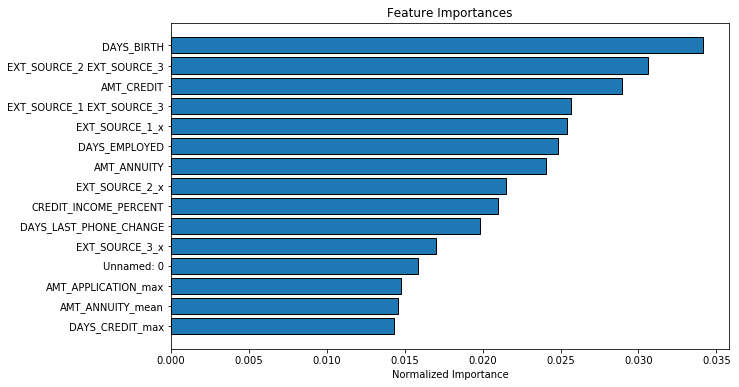

In [17]:
lgbm_params = {
    "boosting":"dart",
    "application":"binary",
    "learning_rate": 0.1,
    'reg_alpha':0.01,
    'reg_lambda': 0.01,
    "n_estimators":10000,
    "max_depth":7,
    "num_leaves":100,
    "max_bin":225,
    "drop_rate":0.02
}

fi, metrics = model(app_train, app_test, lgbm_params=lgbm_params)
print('Baseline metrics')
print(metrics)
fi_sorted = plot_feature_importances(fi)

Training Data Shape:  (215257, 448)
Testing Data Shape:  (46127, 448)
Training until validation scores don't improve for 200 rounds.
[200]	valid's l1: 0.133782	valid's auc: 0.7506	train's l1: 0.120064	train's auc: 0.912934
Early stopping, best iteration is:
[86]	valid's l1: 0.135583	valid's auc: 0.754204	train's l1: 0.128797	train's auc: 0.857283
Training until validation scores don't improve for 200 rounds.
[200]	valid's l1: 0.134541	valid's auc: 0.748257	train's l1: 0.119671	train's auc: 0.911534
Early stopping, best iteration is:
[97]	valid's l1: 0.13609	valid's auc: 0.750568	train's l1: 0.127534	train's auc: 0.864312
Training until validation scores don't improve for 200 rounds.
[200]	valid's l1: 0.133348	valid's auc: 0.739781	train's l1: 0.120461	train's auc: 0.909081
Early stopping, best iteration is:
[98]	valid's l1: 0.134877	valid's auc: 0.741182	train's l1: 0.127649	train's auc: 0.865789
Training until validation scores don't improve for 200 rounds.
[200]	valid's l1: 0.134689	

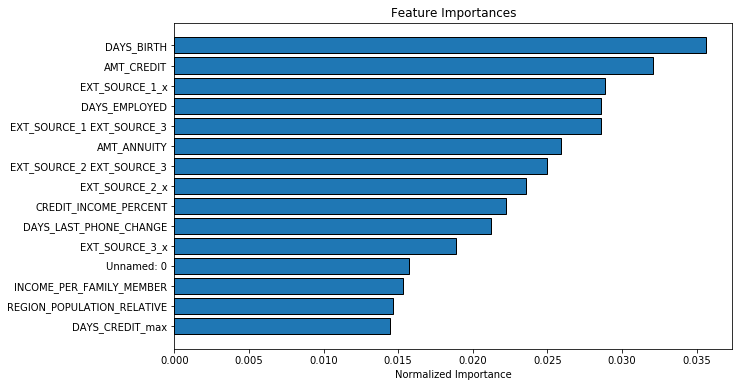

In [18]:
lgbm_params = {
    "boosting":"gbdt",
    "application":"binary",
    "learning_rate": 0.1,
    'reg_alpha':0.1,
    'reg_lambda': 0.1,
    "n_estimators":10000,
    "max_depth":7,
    "num_leaves":200,
    "max_bin":225,
    "drop_rate":0.02
}

fi, metrics = model(app_train, app_test, lgbm_params=lgbm_params)
print('Baseline metrics')
print(metrics)
fi_sorted = plot_feature_importances(fi)

Training Data Shape:  (215257, 448)
Testing Data Shape:  (46127, 448)
Training until validation scores don't improve for 200 rounds.
[200]	valid's l1: 0.135621	valid's auc: 0.755764	train's l1: 0.131104	train's auc: 0.828261
Early stopping, best iteration is:
[134]	valid's l1: 0.135961	valid's auc: 0.756757	train's l1: 0.133003	train's auc: 0.809402
Training until validation scores don't improve for 200 rounds.
[200]	valid's l1: 0.136436	valid's auc: 0.751696	train's l1: 0.130652	train's auc: 0.828086
Early stopping, best iteration is:
[104]	valid's l1: 0.13708	valid's auc: 0.752171	train's l1: 0.133561	train's auc: 0.800085
Training until validation scores don't improve for 200 rounds.
[200]	valid's l1: 0.135294	valid's auc: 0.74148	train's l1: 0.131054	train's auc: 0.829337
Early stopping, best iteration is:
[157]	valid's l1: 0.135511	valid's auc: 0.742536	train's l1: 0.132307	train's auc: 0.817467
Training until validation scores don't improve for 200 rounds.
[200]	valid's l1: 0.136

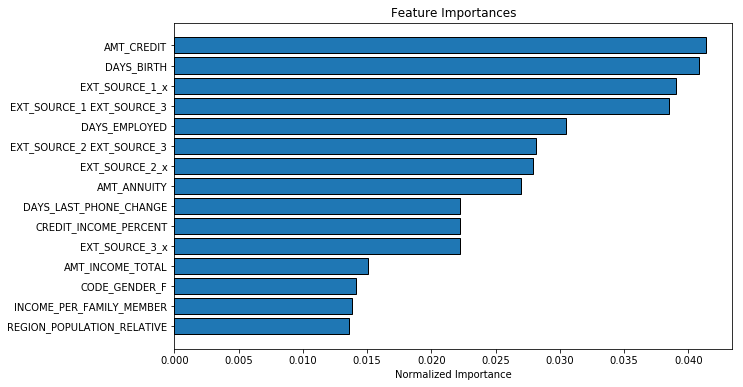

In [19]:
lgbm_params = {
    "boosting":"gbdt",
    "application":"binary",
    "learning_rate": 0.1,
    'reg_alpha':0.1,
    'reg_lambda': 0.1,
    "n_estimators":10000,
    "max_depth":5,
    "num_leaves":200,
    "max_bin":225,
    "drop_rate":0.02
}

fi, metrics = model(app_train, app_test, lgbm_params=lgbm_params)
print('Baseline metrics')
print(metrics)
fi_sorted = plot_feature_importances(fi)

Training Data Shape:  (215257, 448)
Testing Data Shape:  (46127, 448)
Training until validation scores don't improve for 200 rounds.
[200]	valid's l1: 0.135633	valid's auc: 0.7586	train's l1: 0.132768	train's auc: 0.805001
Early stopping, best iteration is:
[199]	valid's l1: 0.135634	valid's auc: 0.758607	train's l1: 0.132783	train's auc: 0.804923
Training until validation scores don't improve for 200 rounds.
[200]	valid's l1: 0.136347	valid's auc: 0.754799	train's l1: 0.132395	train's auc: 0.805111
[400]	valid's l1: 0.135693	valid's auc: 0.753615	train's l1: 0.128439	train's auc: 0.843778
Early stopping, best iteration is:
[224]	valid's l1: 0.136259	valid's auc: 0.755165	train's l1: 0.131917	train's auc: 0.810282
Training until validation scores don't improve for 200 rounds.
[200]	valid's l1: 0.135206	valid's auc: 0.744283	train's l1: 0.132781	train's auc: 0.806472
[400]	valid's l1: 0.134608	valid's auc: 0.744294	train's l1: 0.128805	train's auc: 0.845441
Early stopping, best iteratio

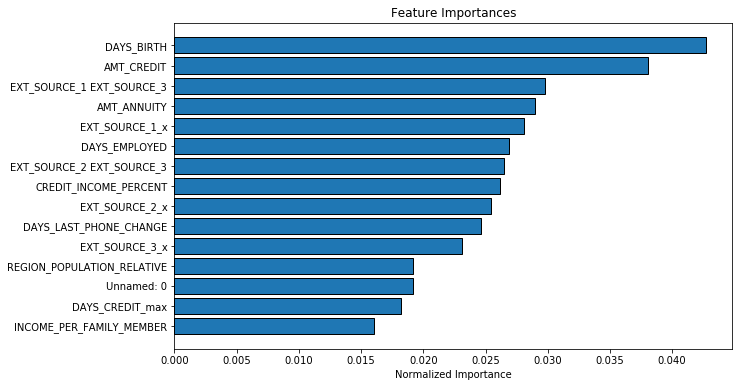

In [20]:
lgbm_params = {
    "boosting":"gbdt",
    "application":"binary",
    "learning_rate": 0.1,
    'reg_alpha':10,
    'reg_lambda': 10,
    "n_estimators":10000,
    "max_depth":5,
    "num_leaves":200,
    "max_bin":225,
    "drop_rate":0.02
}

fi, metrics = model(app_train, app_test, lgbm_params=lgbm_params)
print('Baseline metrics')
print(metrics)
fi_sorted = plot_feature_importances(fi)

In [ ]:
import lightgbm as lgb
from sklearn.model_selection import GridSearchCV, KFold

k_fold = KFold(n_splits = 5, shuffle = True, random_state = 50)

param_grid = {
    "boosting": ["gbdt", "dart"],
    "application":["binary"],
    'learning_rate': [0.01, 0.1, 1, 10],
    'reg_alpha': [0.01, 0.1, 1],
    'reg_lambda': [0.01, 0.1, 1],
    "n_estimators": [10000],
    "max_depth": [3, 5, 7],
    'num_leaves': [31, 127],
    "max_bin": [225],
    'feature_fraction': [0.5, 1.0],
    'bagging_fraction': [0.75, 0.95], 
    "drop_rate": [0.02]
    }

lgbc_fit_params = {
    "eval_names": ['valid', 'train'],
    "eval_set" : [[test, test_labels]],
    'eval_metric' : ['auc', 'mae'], # string, list of strings, callable or None, optional (default=None)
    'early_stopping_rounds' : 200, # int or None, optional (default=None)
    'verbose': 200
}


lgb_Classifier = lgb.LGBMClassifier(
                         bagging_freq=5,
                         eval_metric=['auc', 'mae'],
                         subsample = 0.8, n_jobs = -1, random_state = 50)

gsearch = GridSearchCV(estimator=lgb_Classifier, 
                       param_grid=param_grid, 
                       fit_params=lgbc_fit_params,
                       cv=k_fold,
                       return_train_score=True,
                       scoring='roc_auc') 


lgb_model = gsearch.fit(X=train, 
                        y=train_labels)

print(lgb_model.best_params_, lgb_model.best_score_)


Training until validation scores don't improve for 200 rounds.
[200]	valid's l1: 0.140842	valid's auc: 0.730857
[400]	valid's l1: 0.138804	valid's auc: 0.739924
[600]	valid's l1: 0.137965	valid's auc: 0.744606
[800]	valid's l1: 0.137196	valid's auc: 0.747274
[1000]	valid's l1: 0.136724	valid's auc: 0.74907
[1200]	valid's l1: 0.136531	valid's auc: 0.749953
[1400]	valid's l1: 0.13628	valid's auc: 0.750559
[1600]	valid's l1: 0.136095	valid's auc: 0.750998
[1800]	valid's l1: 0.136012	valid's auc: 0.751282
Early stopping, best iteration is:
[1691]	valid's l1: 0.135957	valid's auc: 0.751139
Training until validation scores don't improve for 200 rounds.
[200]	valid's l1: 0.140574	valid's auc: 0.730909
[400]	valid's l1: 0.138605	valid's auc: 0.73934
[600]	valid's l1: 0.137691	valid's auc: 0.744485
[800]	valid's l1: 0.137102	valid's auc: 0.747226
[1000]	valid's l1: 0.136641	valid's auc: 0.748663
[1200]	valid's l1: 0.136396	valid's auc: 0.749723
[1400]	valid's l1: 0.136182	valid's auc: 0.750303


Training until validation scores don't improve for 200 rounds.
[200]	valid's l1: 0.140837	valid's auc: 0.72997
[400]	valid's l1: 0.138862	valid's auc: 0.73938
[600]	valid's l1: 0.137861	valid's auc: 0.744186
[800]	valid's l1: 0.137291	valid's auc: 0.746803
[1000]	valid's l1: 0.136827	valid's auc: 0.748549
[1200]	valid's l1: 0.136424	valid's auc: 0.749548
[1400]	valid's l1: 0.136346	valid's auc: 0.750332
[1600]	valid's l1: 0.136137	valid's auc: 0.750575
[1800]	valid's l1: 0.135997	valid's auc: 0.75072
[2000]	valid's l1: 0.135881	valid's auc: 0.751048
[2200]	valid's l1: 0.135715	valid's auc: 0.751162
Early stopping, best iteration is:
[2175]	valid's l1: 0.135684	valid's auc: 0.751118
Training until validation scores don't improve for 200 rounds.
[200]	valid's l1: 0.140628	valid's auc: 0.729704
[400]	valid's l1: 0.138762	valid's auc: 0.738774
[600]	valid's l1: 0.137712	valid's auc: 0.744099
[800]	valid's l1: 0.137057	valid's auc: 0.746798
[1000]	valid's l1: 0.136645	valid's auc: 0.748592


[400]	valid's l1: 0.138753	valid's auc: 0.738741
[600]	valid's l1: 0.137722	valid's auc: 0.743994
[800]	valid's l1: 0.137073	valid's auc: 0.746735
[1000]	valid's l1: 0.136664	valid's auc: 0.748498
[1200]	valid's l1: 0.136424	valid's auc: 0.74941
[1400]	valid's l1: 0.13618	valid's auc: 0.750038
[1600]	valid's l1: 0.135986	valid's auc: 0.750491
[1800]	valid's l1: 0.135956	valid's auc: 0.750725
Early stopping, best iteration is:
[1680]	valid's l1: 0.135894	valid's auc: 0.75062
Training until validation scores don't improve for 200 rounds.
[200]	valid's l1: 0.140376	valid's auc: 0.730284
[400]	valid's l1: 0.138432	valid's auc: 0.738969
[600]	valid's l1: 0.137555	valid's auc: 0.743853
[800]	valid's l1: 0.136979	valid's auc: 0.746637
[1000]	valid's l1: 0.136518	valid's auc: 0.74839
[1200]	valid's l1: 0.136132	valid's auc: 0.749395
[1400]	valid's l1: 0.135917	valid's auc: 0.750273
[1600]	valid's l1: 0.135787	valid's auc: 0.750769
[1800]	valid's l1: 0.135628	valid's auc: 0.75087
[2000]	valid's

[1400]	valid's l1: 0.135887	valid's auc: 0.750357
[1600]	valid's l1: 0.135747	valid's auc: 0.750867
[1800]	valid's l1: 0.135576	valid's auc: 0.751034
[2000]	valid's l1: 0.135351	valid's auc: 0.751192
[2200]	valid's l1: 0.135299	valid's auc: 0.751423
[2400]	valid's l1: 0.135229	valid's auc: 0.751579
[2600]	valid's l1: 0.13518	valid's auc: 0.751608
[2800]	valid's l1: 0.135176	valid's auc: 0.751633
[3000]	valid's l1: 0.135056	valid's auc: 0.751704
Early stopping, best iteration is:
[2981]	valid's l1: 0.135066	valid's auc: 0.751719
Training until validation scores don't improve for 200 rounds.
[200]	valid's l1: 0.140854	valid's auc: 0.730725
[400]	valid's l1: 0.138818	valid's auc: 0.739888
[600]	valid's l1: 0.137955	valid's auc: 0.744688
[800]	valid's l1: 0.137169	valid's auc: 0.747301
[1000]	valid's l1: 0.136681	valid's auc: 0.749086
[1200]	valid's l1: 0.136478	valid's auc: 0.750027
[1400]	valid's l1: 0.136221	valid's auc: 0.750708
[1600]	valid's l1: 0.136031	valid's auc: 0.751135
[1800]	

[200]	valid's l1: 0.140842	valid's auc: 0.730857
[400]	valid's l1: 0.138804	valid's auc: 0.739924
[600]	valid's l1: 0.137965	valid's auc: 0.744606
[800]	valid's l1: 0.137196	valid's auc: 0.747274
[1000]	valid's l1: 0.136724	valid's auc: 0.74907
[1200]	valid's l1: 0.136531	valid's auc: 0.749953
[1400]	valid's l1: 0.13628	valid's auc: 0.750559
[1600]	valid's l1: 0.136095	valid's auc: 0.750998
[1800]	valid's l1: 0.136012	valid's auc: 0.751282
Early stopping, best iteration is:
[1691]	valid's l1: 0.135957	valid's auc: 0.751139
Training until validation scores don't improve for 200 rounds.
[200]	valid's l1: 0.140574	valid's auc: 0.730909
[400]	valid's l1: 0.138605	valid's auc: 0.73934
[600]	valid's l1: 0.137691	valid's auc: 0.744485
[800]	valid's l1: 0.137102	valid's auc: 0.747226
[1000]	valid's l1: 0.136641	valid's auc: 0.748663
[1200]	valid's l1: 0.136396	valid's auc: 0.749723
[1400]	valid's l1: 0.136182	valid's auc: 0.750303
[1600]	valid's l1: 0.136076	valid's auc: 0.750671
[1800]	valid'

[200]	valid's l1: 0.140837	valid's auc: 0.72997
[400]	valid's l1: 0.138862	valid's auc: 0.73938
[600]	valid's l1: 0.137861	valid's auc: 0.744186
[800]	valid's l1: 0.137291	valid's auc: 0.746803
[1000]	valid's l1: 0.136827	valid's auc: 0.748549
[1200]	valid's l1: 0.136424	valid's auc: 0.749548
[1400]	valid's l1: 0.136346	valid's auc: 0.750332
[1600]	valid's l1: 0.136137	valid's auc: 0.750575
[1800]	valid's l1: 0.135997	valid's auc: 0.75072
[2000]	valid's l1: 0.135881	valid's auc: 0.751048
[2200]	valid's l1: 0.135715	valid's auc: 0.751162
Early stopping, best iteration is:
[2175]	valid's l1: 0.135684	valid's auc: 0.751118
Training until validation scores don't improve for 200 rounds.
[200]	valid's l1: 0.140628	valid's auc: 0.729704
[400]	valid's l1: 0.138762	valid's auc: 0.738774
[600]	valid's l1: 0.137712	valid's auc: 0.744099
[800]	valid's l1: 0.137057	valid's auc: 0.746798
[1000]	valid's l1: 0.136645	valid's auc: 0.748592
[1200]	valid's l1: 0.136405	valid's auc: 0.749508
[1400]	valid'

[600]	valid's l1: 0.137722	valid's auc: 0.743994
[800]	valid's l1: 0.137073	valid's auc: 0.746735
[1000]	valid's l1: 0.136664	valid's auc: 0.748498
[1200]	valid's l1: 0.136424	valid's auc: 0.74941
[1400]	valid's l1: 0.13618	valid's auc: 0.750038
[1600]	valid's l1: 0.135986	valid's auc: 0.750491
[1800]	valid's l1: 0.135956	valid's auc: 0.750725
Early stopping, best iteration is:
[1680]	valid's l1: 0.135894	valid's auc: 0.75062
Training until validation scores don't improve for 200 rounds.
[200]	valid's l1: 0.140376	valid's auc: 0.730284
[400]	valid's l1: 0.138432	valid's auc: 0.738969
[600]	valid's l1: 0.137555	valid's auc: 0.743853
[800]	valid's l1: 0.136979	valid's auc: 0.746637
[1000]	valid's l1: 0.136518	valid's auc: 0.74839
[1200]	valid's l1: 0.136132	valid's auc: 0.749395
[1400]	valid's l1: 0.135917	valid's auc: 0.750273
[1600]	valid's l1: 0.135787	valid's auc: 0.750769
[1800]	valid's l1: 0.135628	valid's auc: 0.75087
[2000]	valid's l1: 0.135405	valid's auc: 0.751036
[2200]	valid'

[1400]	valid's l1: 0.135887	valid's auc: 0.750357
[1600]	valid's l1: 0.135747	valid's auc: 0.750867
[1800]	valid's l1: 0.135576	valid's auc: 0.751034
[2000]	valid's l1: 0.135351	valid's auc: 0.751192
[2200]	valid's l1: 0.135299	valid's auc: 0.751423
[2400]	valid's l1: 0.135229	valid's auc: 0.751579
[2600]	valid's l1: 0.13518	valid's auc: 0.751608
[2800]	valid's l1: 0.135176	valid's auc: 0.751633
[3000]	valid's l1: 0.135056	valid's auc: 0.751704
Early stopping, best iteration is:
[2981]	valid's l1: 0.135066	valid's auc: 0.751719
Training until validation scores don't improve for 200 rounds.
[200]	valid's l1: 0.140854	valid's auc: 0.730725
[400]	valid's l1: 0.138818	valid's auc: 0.739888
[600]	valid's l1: 0.137955	valid's auc: 0.744688
[800]	valid's l1: 0.137169	valid's auc: 0.747301
[1000]	valid's l1: 0.136681	valid's auc: 0.749086
[1200]	valid's l1: 0.136478	valid's auc: 0.750027
[1400]	valid's l1: 0.136221	valid's auc: 0.750708
[1600]	valid's l1: 0.136031	valid's auc: 0.751135
[1800]	

[200]	valid's l1: 0.139822	valid's auc: 0.740086
[400]	valid's l1: 0.137581	valid's auc: 0.746404
[600]	valid's l1: 0.136733	valid's auc: 0.749633
[800]	valid's l1: 0.136107	valid's auc: 0.750783
[1000]	valid's l1: 0.13577	valid's auc: 0.751367
[1200]	valid's l1: 0.13566	valid's auc: 0.751552
[1400]	valid's l1: 0.135462	valid's auc: 0.751856
[1600]	valid's l1: 0.135311	valid's auc: 0.752026
[1800]	valid's l1: 0.135243	valid's auc: 0.752061
[2000]	valid's l1: 0.135075	valid's auc: 0.751912
Early stopping, best iteration is:
[1852]	valid's l1: 0.135197	valid's auc: 0.752173
Training until validation scores don't improve for 200 rounds.
[200]	valid's l1: 0.139571	valid's auc: 0.740017
[400]	valid's l1: 0.13739	valid's auc: 0.746068
[600]	valid's l1: 0.13647	valid's auc: 0.749277
[800]	valid's l1: 0.135966	valid's auc: 0.750646
[1000]	valid's l1: 0.135625	valid's auc: 0.751236
[1200]	valid's l1: 0.135474	valid's auc: 0.751548
[1400]	valid's l1: 0.135305	valid's auc: 0.75173
[1600]	valid's 

[1800]	valid's l1: 0.134736	valid's auc: 0.752663
[2000]	valid's l1: 0.134527	valid's auc: 0.752639
Early stopping, best iteration is:
[1878]	valid's l1: 0.134597	valid's auc: 0.752792
Training until validation scores don't improve for 200 rounds.
[200]	valid's l1: 0.139826	valid's auc: 0.74005
[400]	valid's l1: 0.137579	valid's auc: 0.746445
[600]	valid's l1: 0.136726	valid's auc: 0.74983
[800]	valid's l1: 0.136091	valid's auc: 0.75099
[1000]	valid's l1: 0.135749	valid's auc: 0.751543
[1200]	valid's l1: 0.135645	valid's auc: 0.751724
[1400]	valid's l1: 0.135455	valid's auc: 0.751904
Early stopping, best iteration is:
[1309]	valid's l1: 0.135525	valid's auc: 0.752038
Training until validation scores don't improve for 200 rounds.
[200]	valid's l1: 0.13957	valid's auc: 0.740033
[400]	valid's l1: 0.137378	valid's auc: 0.74612
[600]	valid's l1: 0.136457	valid's auc: 0.749363
[800]	valid's l1: 0.135951	valid's auc: 0.75071
[1000]	valid's l1: 0.135608	valid's auc: 0.751299
[1200]	valid's l1:

[1200]	valid's l1: 0.135171	valid's auc: 0.751763
[1400]	valid's l1: 0.135016	valid's auc: 0.752239
[1600]	valid's l1: 0.134928	valid's auc: 0.752354
Early stopping, best iteration is:
[1525]	valid's l1: 0.134967	valid's auc: 0.752411
Training until validation scores don't improve for 200 rounds.
[200]	valid's l1: 0.139834	valid's auc: 0.740012
[400]	valid's l1: 0.137552	valid's auc: 0.746322
[600]	valid's l1: 0.136682	valid's auc: 0.749789
[800]	valid's l1: 0.136028	valid's auc: 0.751068
[1000]	valid's l1: 0.135666	valid's auc: 0.751865
[1200]	valid's l1: 0.135558	valid's auc: 0.751917
[1400]	valid's l1: 0.135358	valid's auc: 0.752192
[1600]	valid's l1: 0.135222	valid's auc: 0.75221
Early stopping, best iteration is:
[1571]	valid's l1: 0.135258	valid's auc: 0.75229
Training until validation scores don't improve for 200 rounds.
[200]	valid's l1: 0.139571	valid's auc: 0.740027
[400]	valid's l1: 0.137358	valid's auc: 0.746291
[600]	valid's l1: 0.136434	valid's auc: 0.749576
[800]	valid's

[800]	valid's l1: 0.135771	valid's auc: 0.751098
[1000]	valid's l1: 0.135426	valid's auc: 0.751717
[1200]	valid's l1: 0.135118	valid's auc: 0.752066
[1400]	valid's l1: 0.134948	valid's auc: 0.75254
[1600]	valid's l1: 0.134862	valid's auc: 0.752665
[1800]	valid's l1: 0.134705	valid's auc: 0.752735
[2000]	valid's l1: 0.134482	valid's auc: 0.752729
Early stopping, best iteration is:
[1878]	valid's l1: 0.134571	valid's auc: 0.752835
Training until validation scores don't improve for 200 rounds.
[200]	valid's l1: 0.139823	valid's auc: 0.740053
[400]	valid's l1: 0.137588	valid's auc: 0.746381
[600]	valid's l1: 0.136731	valid's auc: 0.749801
[800]	valid's l1: 0.136096	valid's auc: 0.750974
[1000]	valid's l1: 0.135753	valid's auc: 0.751497
[1200]	valid's l1: 0.135646	valid's auc: 0.751688
[1400]	valid's l1: 0.135462	valid's auc: 0.751831
[1600]	valid's l1: 0.13531	valid's auc: 0.752057
[1800]	valid's l1: 0.135245	valid's auc: 0.752026
Early stopping, best iteration is:
[1690]	valid's l1: 0.135

Training until validation scores don't improve for 200 rounds.
[200]	valid's l1: 0.139335	valid's auc: 0.739752
[400]	valid's l1: 0.137172	valid's auc: 0.745862
[600]	valid's l1: 0.1363	valid's auc: 0.749317
[800]	valid's l1: 0.135808	valid's auc: 0.750788
[1000]	valid's l1: 0.135473	valid's auc: 0.751393
[1200]	valid's l1: 0.135176	valid's auc: 0.751815
[1400]	valid's l1: 0.135016	valid's auc: 0.752327
[1600]	valid's l1: 0.13493	valid's auc: 0.752398
[1800]	valid's l1: 0.134767	valid's auc: 0.752401
[2000]	valid's l1: 0.134557	valid's auc: 0.752345
Early stopping, best iteration is:
[1878]	valid's l1: 0.134627	valid's auc: 0.752539
Training until validation scores don't improve for 200 rounds.
[200]	valid's l1: 0.139822	valid's auc: 0.740007
[400]	valid's l1: 0.137586	valid's auc: 0.746415
[600]	valid's l1: 0.136734	valid's auc: 0.749689
[800]	valid's l1: 0.136089	valid's auc: 0.751005
[1000]	valid's l1: 0.135752	valid's auc: 0.751572
[1200]	valid's l1: 0.13564	valid's auc: 0.751743
[

[1000]	valid's l1: 0.135603	valid's auc: 0.752557
[1200]	valid's l1: 0.13548	valid's auc: 0.752698
[1400]	valid's l1: 0.135297	valid's auc: 0.753002
[1600]	valid's l1: 0.135143	valid's auc: 0.752981
Early stopping, best iteration is:
[1516]	valid's l1: 0.135214	valid's auc: 0.753083
Training until validation scores don't improve for 200 rounds.
[200]	valid's l1: 0.139338	valid's auc: 0.739771
[400]	valid's l1: 0.137166	valid's auc: 0.745858
[600]	valid's l1: 0.136275	valid's auc: 0.74923
[800]	valid's l1: 0.13578	valid's auc: 0.750767
[1000]	valid's l1: 0.135443	valid's auc: 0.7514
[1200]	valid's l1: 0.135145	valid's auc: 0.751852
[1400]	valid's l1: 0.13499	valid's auc: 0.752366
[1600]	valid's l1: 0.13491	valid's auc: 0.752454
[1800]	valid's l1: 0.13475	valid's auc: 0.752504
[2000]	valid's l1: 0.134541	valid's auc: 0.75238
Early stopping, best iteration is:
[1878]	valid's l1: 0.134614	valid's auc: 0.752611
Training until validation scores don't improve for 200 rounds.
[200]	valid's l1:

[1000]	valid's l1: 0.13556	valid's auc: 0.752447
[1200]	valid's l1: 0.135423	valid's auc: 0.752676
[1400]	valid's l1: 0.135253	valid's auc: 0.752815
[1600]	valid's l1: 0.135108	valid's auc: 0.752852
Early stopping, best iteration is:
[1552]	valid's l1: 0.135186	valid's auc: 0.75297
Training until validation scores don't improve for 200 rounds.
[200]	valid's l1: 0.139359	valid's auc: 0.739834
[400]	valid's l1: 0.137177	valid's auc: 0.74606
[600]	valid's l1: 0.136266	valid's auc: 0.749664
[800]	valid's l1: 0.135755	valid's auc: 0.751058
[1000]	valid's l1: 0.135407	valid's auc: 0.751706
[1200]	valid's l1: 0.135106	valid's auc: 0.752006
[1400]	valid's l1: 0.134931	valid's auc: 0.752527
[1600]	valid's l1: 0.134856	valid's auc: 0.752526
[1800]	valid's l1: 0.134702	valid's auc: 0.752654
[2000]	valid's l1: 0.134478	valid's auc: 0.752672
Early stopping, best iteration is:
[1897]	valid's l1: 0.134578	valid's auc: 0.752757
Training until validation scores don't improve for 200 rounds.
[200]	valid

[1000]	valid's l1: 0.135144	valid's auc: 0.751557
[1200]	valid's l1: 0.13487	valid's auc: 0.751688
[1400]	valid's l1: 0.13471	valid's auc: 0.752109
Early stopping, best iteration is:
[1385]	valid's l1: 0.134704	valid's auc: 0.752118
Training until validation scores don't improve for 200 rounds.
[200]	valid's l1: 0.139443	valid's auc: 0.741697
[400]	valid's l1: 0.137158	valid's auc: 0.747473
[600]	valid's l1: 0.136337	valid's auc: 0.750378
[800]	valid's l1: 0.135755	valid's auc: 0.751368
[1000]	valid's l1: 0.135447	valid's auc: 0.751876
[1200]	valid's l1: 0.135348	valid's auc: 0.751942
[1400]	valid's l1: 0.135148	valid's auc: 0.752165
[1600]	valid's l1: 0.13497	valid's auc: 0.752277
Early stopping, best iteration is:
[1569]	valid's l1: 0.135012	valid's auc: 0.752402
Training until validation scores don't improve for 200 rounds.
[200]	valid's l1: 0.139182	valid's auc: 0.741899
[400]	valid's l1: 0.136946	valid's auc: 0.747156
[600]	valid's l1: 0.136056	valid's auc: 0.75003
[800]	valid's l

Early stopping, best iteration is:
[1312]	valid's l1: 0.135181	valid's auc: 0.751953
Training until validation scores don't improve for 200 rounds.
[200]	valid's l1: 0.139169	valid's auc: 0.742104
[400]	valid's l1: 0.136892	valid's auc: 0.747554
[600]	valid's l1: 0.135999	valid's auc: 0.750454
[800]	valid's l1: 0.13555	valid's auc: 0.751627
[1000]	valid's l1: 0.135239	valid's auc: 0.751939
[1200]	valid's l1: 0.135091	valid's auc: 0.752306
Early stopping, best iteration is:
[1175]	valid's l1: 0.135097	valid's auc: 0.75237
Training until validation scores don't improve for 200 rounds.
[200]	valid's l1: 0.139387	valid's auc: 0.740981
[400]	valid's l1: 0.13715	valid's auc: 0.747101
[600]	valid's l1: 0.136191	valid's auc: 0.74976
[800]	valid's l1: 0.135705	valid's auc: 0.751213
[1000]	valid's l1: 0.135393	valid's auc: 0.75175
[1200]	valid's l1: 0.13511	valid's auc: 0.751918
[1400]	valid's l1: 0.135086	valid's auc: 0.752242
Early stopping, best iteration is:
[1375]	valid's l1: 0.135112	valid

[800]	valid's l1: 0.135218	valid's auc: 0.750315
[1000]	valid's l1: 0.134796	valid's auc: 0.750531
[1200]	valid's l1: 0.134385	valid's auc: 0.750525
Early stopping, best iteration is:
[1054]	valid's l1: 0.134707	valid's auc: 0.750651
Training until validation scores don't improve for 200 rounds.
[200]	valid's l1: 0.138981	valid's auc: 0.7438
[400]	valid's l1: 0.136744	valid's auc: 0.747876
[600]	valid's l1: 0.135657	valid's auc: 0.750413
[800]	valid's l1: 0.135101	valid's auc: 0.751341
[1000]	valid's l1: 0.134736	valid's auc: 0.751757
[1200]	valid's l1: 0.134464	valid's auc: 0.751943
[1400]	valid's l1: 0.134142	valid's auc: 0.752184
[1600]	valid's l1: 0.133811	valid's auc: 0.751998
Early stopping, best iteration is:
[1487]	valid's l1: 0.134015	valid's auc: 0.752292
Training until validation scores don't improve for 200 rounds.
[200]	valid's l1: 0.138769	valid's auc: 0.742772
[400]	valid's l1: 0.136427	valid's auc: 0.747299
[600]	valid's l1: 0.135501	valid's auc: 0.749817
[800]	valid's 

[400]	valid's l1: 0.136722	valid's auc: 0.748556
[600]	valid's l1: 0.135874	valid's auc: 0.750338
[800]	valid's l1: 0.135222	valid's auc: 0.750981
[1000]	valid's l1: 0.134843	valid's auc: 0.751283
[1200]	valid's l1: 0.134624	valid's auc: 0.751085
Early stopping, best iteration is:
[1046]	valid's l1: 0.134747	valid's auc: 0.751384
Training until validation scores don't improve for 200 rounds.
[200]	valid's l1: 0.138901	valid's auc: 0.743474
[400]	valid's l1: 0.136525	valid's auc: 0.747712
[600]	valid's l1: 0.135586	valid's auc: 0.75018
[800]	valid's l1: 0.13504	valid's auc: 0.751098
[1000]	valid's l1: 0.134635	valid's auc: 0.751393
[1200]	valid's l1: 0.134366	valid's auc: 0.751573
[1400]	valid's l1: 0.134018	valid's auc: 0.75174
Early stopping, best iteration is:
[1380]	valid's l1: 0.134024	valid's auc: 0.751769
Training until validation scores don't improve for 200 rounds.
[200]	valid's l1: 0.139096	valid's auc: 0.742992
[400]	valid's l1: 0.136781	valid's auc: 0.746985
[600]	valid's l1

[1200]	valid's l1: 0.134212	valid's auc: 0.751623
[1400]	valid's l1: 0.134015	valid's auc: 0.751757
Early stopping, best iteration is:
[1357]	valid's l1: 0.134054	valid's auc: 0.751924
Training until validation scores don't improve for 200 rounds.
[200]	valid's l1: 0.138909	valid's auc: 0.743851
[400]	valid's l1: 0.136646	valid's auc: 0.748149
[600]	valid's l1: 0.135538	valid's auc: 0.750647
[800]	valid's l1: 0.135008	valid's auc: 0.75136
[1000]	valid's l1: 0.134617	valid's auc: 0.752179
[1200]	valid's l1: 0.134335	valid's auc: 0.752452
[1400]	valid's l1: 0.133982	valid's auc: 0.752559
Early stopping, best iteration is:
[1360]	valid's l1: 0.134047	valid's auc: 0.752593
Training until validation scores don't improve for 200 rounds.
[200]	valid's l1: 0.138681	valid's auc: 0.74354
[400]	valid's l1: 0.136317	valid's auc: 0.7482
[600]	valid's l1: 0.135377	valid's auc: 0.750592
[800]	valid's l1: 0.134867	valid's auc: 0.751069
[1000]	valid's l1: 0.134461	valid's auc: 0.75132
[1200]	valid's l1

Training until validation scores don't improve for 200 rounds.
[200]	valid's l1: 0.136051	valid's auc: 0.750001
[400]	valid's l1: 0.135491	valid's auc: 0.750273
Early stopping, best iteration is:
[286]	valid's l1: 0.135526	valid's auc: 0.750775
Training until validation scores don't improve for 200 rounds.
[200]	valid's l1: 0.135681	valid's auc: 0.750218
[400]	valid's l1: 0.135381	valid's auc: 0.750287
Early stopping, best iteration is:
[229]	valid's l1: 0.135334	valid's auc: 0.750784
Training until validation scores don't improve for 200 rounds.
[200]	valid's l1: 0.135947	valid's auc: 0.749238
[400]	valid's l1: 0.135388	valid's auc: 0.749655
Early stopping, best iteration is:
[306]	valid's l1: 0.13559	valid's auc: 0.750011
Training until validation scores don't improve for 200 rounds.
[200]	valid's l1: 0.135749	valid's auc: 0.75032
[400]	valid's l1: 0.135396	valid's auc: 0.748761
Early stopping, best iteration is:
[233]	valid's l1: 0.135572	valid's auc: 0.750769
Training until validat

Early stopping, best iteration is:
[186]	valid's l1: 0.135504	valid's auc: 0.750372
Training until validation scores don't improve for 200 rounds.
[200]	valid's l1: 0.13586	valid's auc: 0.750711
[400]	valid's l1: 0.135475	valid's auc: 0.749978
Early stopping, best iteration is:
[247]	valid's l1: 0.135665	valid's auc: 0.750945
Training until validation scores don't improve for 200 rounds.
[200]	valid's l1: 0.135769	valid's auc: 0.750696
[400]	valid's l1: 0.135405	valid's auc: 0.750978
Early stopping, best iteration is:
[294]	valid's l1: 0.135279	valid's auc: 0.751542
Training until validation scores don't improve for 200 rounds.
[200]	valid's l1: 0.135914	valid's auc: 0.749438
[400]	valid's l1: 0.135359	valid's auc: 0.749896
Early stopping, best iteration is:
[356]	valid's l1: 0.135274	valid's auc: 0.750672
Training until validation scores don't improve for 200 rounds.
[200]	valid's l1: 0.135699	valid's auc: 0.750116
[400]	valid's l1: 0.135343	valid's auc: 0.748309
Early stopping, best 

Training until validation scores don't improve for 200 rounds.
[200]	valid's l1: 0.135295	valid's auc: 0.750727
Early stopping, best iteration is:
[185]	valid's l1: 0.135432	valid's auc: 0.751087
Training until validation scores don't improve for 200 rounds.
[200]	valid's l1: 0.135217	valid's auc: 0.746593
Early stopping, best iteration is:
[101]	valid's l1: 0.135848	valid's auc: 0.748235
Training until validation scores don't improve for 200 rounds.
[200]	valid's l1: 0.135042	valid's auc: 0.748787
[400]	valid's l1: 0.134104	valid's auc: 0.747346
Early stopping, best iteration is:
[230]	valid's l1: 0.134629	valid's auc: 0.749276
Training until validation scores don't improve for 200 rounds.
[200]	valid's l1: 0.135239	valid's auc: 0.747201
Early stopping, best iteration is:
[127]	valid's l1: 0.135541	valid's auc: 0.747857
Training until validation scores don't improve for 200 rounds.
[200]	valid's l1: 0.134983	valid's auc: 0.749544
Early stopping, best iteration is:
[175]	valid's l1: 0.

[200]	valid's l1: 0.13516	valid's auc: 0.747376
Early stopping, best iteration is:
[78]	valid's l1: 0.136225	valid's auc: 0.748946
Training until validation scores don't improve for 200 rounds.
[200]	valid's l1: 0.134968	valid's auc: 0.748634
Early stopping, best iteration is:
[111]	valid's l1: 0.13546	valid's auc: 0.749535
Training until validation scores don't improve for 200 rounds.
[200]	valid's l1: 0.135071	valid's auc: 0.749431
[400]	valid's l1: 0.134309	valid's auc: 0.746525
Early stopping, best iteration is:
[228]	valid's l1: 0.134761	valid's auc: 0.749684
Training until validation scores don't improve for 200 rounds.
[200]	valid's l1: 0.134827	valid's auc: 0.749124
Early stopping, best iteration is:
[130]	valid's l1: 0.135481	valid's auc: 0.750061
Training until validation scores don't improve for 200 rounds.
[200]	valid's l1: 0.134573	valid's auc: 0.748898
Early stopping, best iteration is:
[101]	valid's l1: 0.135068	valid's auc: 0.751015
Training until validation scores don'

Early stopping, best iteration is:
[146]	valid's l1: 0.135241	valid's auc: 0.74967
Training until validation scores don't improve for 200 rounds.
[200]	valid's l1: 0.135064	valid's auc: 0.748392
[400]	valid's l1: 0.134011	valid's auc: 0.746546
Early stopping, best iteration is:
[236]	valid's l1: 0.134684	valid's auc: 0.74879
Training until validation scores don't improve for 200 rounds.
[200]	valid's l1: 0.134932	valid's auc: 0.749322
Early stopping, best iteration is:
[126]	valid's l1: 0.135371	valid's auc: 0.750525
Training until validation scores don't improve for 200 rounds.
[200]	valid's l1: 0.134501	valid's auc: 0.748787
Early stopping, best iteration is:
[111]	valid's l1: 0.135115	valid's auc: 0.750049
Training until validation scores don't improve for 200 rounds.
[200]	valid's l1: 0.135293	valid's auc: 0.747912
Early stopping, best iteration is:
[89]	valid's l1: 0.13592	valid's auc: 0.749943
Training until validation scores don't improve for 200 rounds.
[200]	valid's l1: 0.1349

[200]	valid's l1: 0.134791	valid's auc: 0.746567
Early stopping, best iteration is:
[130]	valid's l1: 0.135409	valid's auc: 0.74947
Training until validation scores don't improve for 200 rounds.
[200]	valid's l1: 0.134209	valid's auc: 0.746924
Early stopping, best iteration is:
[113]	valid's l1: 0.134879	valid's auc: 0.749303
Training until validation scores don't improve for 200 rounds.
[200]	valid's l1: 0.134702	valid's auc: 0.746233
Early stopping, best iteration is:
[79]	valid's l1: 0.135976	valid's auc: 0.74909
Training until validation scores don't improve for 200 rounds.
[200]	valid's l1: 0.134676	valid's auc: 0.747259
Early stopping, best iteration is:
[138]	valid's l1: 0.134965	valid's auc: 0.748203
Training until validation scores don't improve for 200 rounds.
[200]	valid's l1: 0.134807	valid's auc: 0.745151
Early stopping, best iteration is:
[127]	valid's l1: 0.135076	valid's auc: 0.748062
Training until validation scores don't improve for 200 rounds.
[200]	valid's l1: 0.134

Early stopping, best iteration is:
[79]	valid's l1: 0.135356	valid's auc: 0.745127
Training until validation scores don't improve for 200 rounds.
[200]	valid's l1: 0.133138	valid's auc: 0.740918
Early stopping, best iteration is:
[77]	valid's l1: 0.135188	valid's auc: 0.743944
Training until validation scores don't improve for 200 rounds.
[200]	valid's l1: 0.133162	valid's auc: 0.742292
Early stopping, best iteration is:
[83]	valid's l1: 0.135066	valid's auc: 0.746141
Training until validation scores don't improve for 200 rounds.
[200]	valid's l1: 0.133236	valid's auc: 0.742704
Early stopping, best iteration is:
[78]	valid's l1: 0.135373	valid's auc: 0.746734
Training until validation scores don't improve for 200 rounds.
[200]	valid's l1: 0.132732	valid's auc: 0.743429
Early stopping, best iteration is:
[86]	valid's l1: 0.134683	valid's auc: 0.7465
Training until validation scores don't improve for 200 rounds.
[200]	valid's l1: 0.133545	valid's auc: 0.740693
Early stopping, best iterat

Training until validation scores don't improve for 200 rounds.
[200]	valid's l1: 0.134872	valid's auc: 0.702052
Early stopping, best iteration is:
[18]	valid's l1: 0.135342	valid's auc: 0.733252
Training until validation scores don't improve for 200 rounds.
[200]	valid's l1: 0.134443	valid's auc: 0.698436
Early stopping, best iteration is:
[13]	valid's l1: 0.135624	valid's auc: 0.738979
Training until validation scores don't improve for 200 rounds.
[200]	valid's l1: 0.135053	valid's auc: 0.702283
Early stopping, best iteration is:
[16]	valid's l1: 0.135892	valid's auc: 0.73641
Training until validation scores don't improve for 200 rounds.
[200]	valid's l1: 0.13549	valid's auc: 0.702904
Early stopping, best iteration is:
[11]	valid's l1: 0.136045	valid's auc: 0.73662
Training until validation scores don't improve for 200 rounds.
[200]	valid's l1: 0.135039	valid's auc: 0.700673
Early stopping, best iteration is:
[12]	valid's l1: 0.136568	valid's auc: 0.732884
Training until validation sc

[200]	valid's l1: 0.134315	valid's auc: 0.699779
Early stopping, best iteration is:
[15]	valid's l1: 0.135912	valid's auc: 0.733676
Training until validation scores don't improve for 200 rounds.
[200]	valid's l1: 0.134936	valid's auc: 0.701868
Early stopping, best iteration is:
[22]	valid's l1: 0.134724	valid's auc: 0.738559
Training until validation scores don't improve for 200 rounds.
[200]	valid's l1: 0.135117	valid's auc: 0.696246
Early stopping, best iteration is:
[12]	valid's l1: 0.136691	valid's auc: 0.733389
Training until validation scores don't improve for 200 rounds.
[200]	valid's l1: 0.134872	valid's auc: 0.702052
Early stopping, best iteration is:
[18]	valid's l1: 0.135342	valid's auc: 0.733252
Training until validation scores don't improve for 200 rounds.
[200]	valid's l1: 0.134443	valid's auc: 0.698436
Early stopping, best iteration is:
[13]	valid's l1: 0.135624	valid's auc: 0.738979
Training until validation scores don't improve for 200 rounds.
[200]	valid's l1: 0.13505

In [ ]:
https://www.kaggle.com/willkoehrsen/intro-to-model-tuning-grid-and-random-search